# Get AL Neurons (Hemibrain v1.2)

### What this notebook does

- Uses neurons provided from [Schlegel, Bates, et al 2020](https://www.biorxiv.org/content/10.1101/2020.12.15.401257v3) to fetch neuron + synapse information from the Hemibrain API
- Saves a table of neurons, `df_neur_ids`, and a connectivity matrix, `al_block`, for use in simulations


### Helpful links
- Documentation for Janelia's API is found here:
    - https://connectome-neuprint.github.io/neuprint-python/docs/api.html
- Intro to the Hemibrain dataset:
    - https://www.janelia.org/sites/default/files/Project%20Teams/Fly%20EM/1.1%20191004_HemibrainDataset.pdf

In [1]:
import os
import sys
import time
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits import mplot3d
import seaborn as sns


from neuprint import Client, queries, NeuronCriteria as NC, SynapseCriteria as SC

In [2]:
# set location of ALVariability/
project_dir = '..'

sys.path.append(project_dir)
from utils.plot_utils import set_font_sizes, plot_value_counts_of_series

set_font_sizes()

### Set Hemibrain query access token

To access Hemibrain data from Janelia's server, you need to provide a user access token. 

Use a Google account to sign in to https://neuprint.janelia.org, -- you will see a personalized Auth Token in https://neuprint.janelia.org/account. This is what you provide as `token` in the hemibrain's `Client` object.

You could just paste your own token into this notebook, or you could make a new file, like `hemibrain_access_token.py`, in this directory with a single variable in it that stores your personal Auth Token: `my_token = 'PastedAuthTokenHere`.

In [4]:
# import your token from a file, hemibrain_access_token.py
# or, just define it here:
# my_token = 'Pasted Auth Token from https://neuprint.janelia.org/account'
from hemibrain_access_token import my_token
c = Client('neuprint.janelia.org', 
           dataset='hemibrain:v1.2.1', 
           token=my_token)
c.fetch_version()

'0.1.0'

In [4]:
out_dir = 'hemibrain_v1_2'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

### Import Schlegel, Bates 2020 data

Use neurons identified in https://www.biorxiv.org/content/10.1101/2020.12.15.401257v3 for use in the model.

(Retrieved December 22, 2020)

In [5]:
schlegel_orn_df = pd.read_csv(os.path.join(project_dir, 'datasets/SchlegelBates2020/S3_hemibrain_ALRN_meta.csv'))
schlegel_ln_df = pd.read_csv(os.path.join(project_dir, 'datasets/SchlegelBates2020/S4_hemibrain_ALLN_meta.csv'))
schlegel_pn_df = pd.read_csv(os.path.join(project_dir, 'datasets/SchlegelBates2020/S5_hemibrain_ALPN_meta.csv'))

In [6]:
schlegel_ln_df.shape

(197, 28)

In [7]:
# define non-olfactory glomeruli
thermo_hygro_gloms = np.array(['VP1d', 'VP1l', 'VP1m', 'VP2', 'VP3', 'VP4', 'VP5'])

In [8]:
# take only ORNs of olfactory glomeruli
df_orns = schlegel_orn_df[(~schlegel_orn_df.glomerulus.isin(thermo_hygro_gloms)) & 
                          (~schlegel_orn_df.glomerulus.isna())]

# extract glomerulus names
olfactory_gloms = df_orns.glomerulus.value_counts().index.values
all_gloms = np.concatenate((olfactory_gloms, thermo_hygro_gloms))

# convert each glomerulus to its ROI name in the hemibrain API (i.e. DM2 --> AL-DM2(R))
olfactory_glom_roi_names = np.array([f'AL-{g}(R)' for g in olfactory_gloms])
all_glom_roi_names = np.array([f'AL-{g}(R)' for g in all_gloms])

df_lns = schlegel_ln_df
df_upns = schlegel_pn_df[schlegel_pn_df.glomerulus.isin(olfactory_gloms)]
df_mpns = schlegel_pn_df[schlegel_pn_df.glomerulus == 'mPN']

### Retrieve neurons from hemibrain API

In [9]:
df_hemi_orn_neurons, df_hemi_orn_roi_counts = queries.fetch_neurons(NC(bodyId=df_orns.bodyid))
df_hemi_ln_neurons, df_hemi_ln_roi_counts = queries.fetch_neurons(NC(bodyId=df_lns.bodyid))
df_hemi_upn_neurons, df_hemi_upn_roi_counts = queries.fetch_neurons(NC(bodyId=df_upns.bodyid))
df_hemi_mpn_neurons, df_hemi_mpn_roi_counts = queries.fetch_neurons(NC(bodyId=df_mpns.bodyid))

In [10]:
df_hemi_orns = df_hemi_orn_neurons.copy()[['bodyId', 'type', 'instance']]
df_hemi_orns['altype'] = 'ORN'
df_hemi_lns = df_hemi_ln_neurons.copy()[['bodyId', 'type', 'instance']]
df_hemi_lns['altype'] = 'LN'
df_hemi_upns = df_hemi_upn_neurons.copy()[['bodyId', 'type', 'instance']]
df_hemi_upns['altype'] = 'uPN'
df_hemi_mpns = df_hemi_mpn_neurons.copy()[['bodyId', 'type', 'instance']]
df_hemi_mpns['altype'] = 'mPN'

df_neur_ids = pd.concat((df_hemi_orns, 
                         df_hemi_lns,
                         df_hemi_upns,
                         df_hemi_mpns)).reset_index(drop=True)
df_neur_ids

,bodyId,type,instance,altype
0,1543124896,ORN_DM3,ORN_DM3_L,ORN
1,1543124950,ORN_DM3,ORN_DM3_L,ORN
2,1543124957,ORN_DM3,ORN_DM3_L,ORN
3,1574159751,ORN_DL5,ORN_DL5_R,ORN
4,1574159997,ORN_DL5,ORN_DL5_R,ORN
...,...,...,...,...
3062,5813079228,M_lvPNm30,M_lvPNm30_R,mPN
3063,5813083723,M_l2PNm17,M_l2PNm17_R,mPN
3064,5813090752,M_vPNml81,M_vPNml81_R,mPN
3065,5901194250,M_lvPNm37,M_lvPNm37_R,mPN


In [11]:
df_neur_ids['altype'].value_counts()

ORN    2574
LN      197
mPN     166
uPN     130
Name: altype, dtype: int64

Now retrieve all synapses between the above neurons:

In [12]:
all_bodyIds = df_neur_ids.bodyId
n_bodyIds = len(all_bodyIds)

In [13]:
(traced_neurons_df, roi_conn_df_nonprim) = queries.fetch_adjacencies(
        sources=all_bodyIds,
        targets=all_bodyIds,
        include_nonprimary=True)

  0%|          | 0/16 [00:00<?, ?it/s]

In [14]:
df_synapses_long = roi_conn_df_nonprim[roi_conn_df_nonprim['roi'] == 'AL(R)']
df_synapses_long.head()

,bodyId_pre,bodyId_post,roi,weight
0,294792184,1447205602,AL(R),1
6,294792184,1857825571,AL(R),1
11,329599710,542634818,AL(R),2
13,329599710,609924156,AL(R),1
15,329599710,635062078,AL(R),5


In [15]:
# AL(R) and the nonprimary ROIs (glomeruli)
relevant_rois = np.concatenate((['AL(R)'], all_glom_roi_names))

In [16]:
df_synapses_all_ROIs = (roi_conn_df_nonprim
                        [roi_conn_df_nonprim.roi.isin(relevant_rois)]
                        .sort_values(['bodyId_pre', 'bodyId_post'])
                        .pivot(index=['bodyId_pre', 'bodyId_post'], 
                                                  columns='roi', 
                                                  values='weight')
                       )

df_synapses_all_ROIs.loc[:, 'nonprimary_sum'] = df_synapses_all_ROIs.loc[:, all_glom_roi_names].sum(1)
df_synapses_all_ROIs['other'] = df_synapses_all_ROIs['AL(R)'] - df_synapses_all_ROIs['nonprimary_sum']
df_synapses_all_ROIs = df_synapses_all_ROIs.drop(columns='nonprimary_sum').reset_index()
df_synapses_all_ROIs.columns.name = ''
df_synapses_all_ROIs

,bodyId_pre,bodyId_post,AL(R),AL-D(R),AL-DA1(R),AL-DA2(R),AL-DA3(R),AL-DA4l(R),AL-DA4m(R),AL-DC1(R),...,AL-VM7d(R),AL-VM7v(R),AL-VP1d(R),AL-VP1l(R),AL-VP1m(R),AL-VP2(R),AL-VP3(R),AL-VP4(R),AL-VP5(R),other
0,294792184,1447205602,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,294792184,1857825571,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,329599710,542634818,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,329599710,609924156,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,329599710,635062078,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194667,7112613444,5813075196,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
194668,7112613444,5813076969,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
194669,7112613444,5813078133,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
194670,7112613444,5901194250,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [17]:
df_synapses_pre = df_synapses_all_ROIs.groupby('bodyId_pre').sum().drop(columns='bodyId_post')
df_synapses_pre

,AL(R),AL-D(R),AL-DA1(R),AL-DA2(R),AL-DA3(R),AL-DA4l(R),AL-DA4m(R),AL-DC1(R),AL-DC2(R),AL-DC3(R),...,AL-VM7d(R),AL-VM7v(R),AL-VP1d(R),AL-VP1l(R),AL-VP1m(R),AL-VP2(R),AL-VP3(R),AL-VP4(R),AL-VP5(R),other
bodyId_pre,,,,,,,,,,,,,,,,,,,,,
294792184,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
329599710,184.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
417199910,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
542311358,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
542634818,4386.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5901215173,130.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5901218894,15416.0,346.0,339.0,144.0,112.0,1.0,10.0,531.0,152.0,255.0,...,155.0,179.0,558.0,74.0,229.0,179.0,151.0,167.0,171.0,95.0
5901221329,258.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
df_synapses_post = df_synapses_all_ROIs.groupby('bodyId_post').sum().drop(columns='bodyId_pre')
df_synapses_post

,AL(R),AL-D(R),AL-DA1(R),AL-DA2(R),AL-DA3(R),AL-DA4l(R),AL-DA4m(R),AL-DC1(R),AL-DC2(R),AL-DC3(R),...,AL-VM7d(R),AL-VM7v(R),AL-VP1d(R),AL-VP1l(R),AL-VP1m(R),AL-VP2(R),AL-VP3(R),AL-VP4(R),AL-VP5(R),other
bodyId_post,,,,,,,,,,,,,,,,,,,,,
294792184,108.0,1.0,0.0,11.0,0.0,0.0,5.0,42.0,6.0,0.0,...,0.0,3.0,0.0,5.0,0.0,0.0,0.0,9.0,0.0,3.0
329599710,122.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0
417199910,46.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,18.0,0.0,1.0,4.0,5.0,0.0,0.0
480927537,77.0,0.0,0.0,13.0,0.0,0.0,5.0,28.0,10.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0
481268653,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5901215173,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5901218894,16688.0,333.0,420.0,150.0,142.0,2.0,9.0,510.0,174.0,254.0,...,203.0,213.0,488.0,84.0,219.0,145.0,122.0,158.0,164.0,104.0
5901221329,139.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
df_synapses_tot = df_synapses_pre.add(df_synapses_post, fill_value=0)

In [20]:
df_synapses = df_synapses_long.pivot('bodyId_pre', 'bodyId_post', 'weight')
df_synapses

bodyId_post,294792184,329599710,417199910,480927537,481268653,541632990,542311358,542634818,542652506,542665377,...,5901206814,5901209981,5901210175,5901210481,5901210546,5901215173,5901218894,5901221329,5901222910,7112613444
bodyId_pre,,,,,,,,,,,,,,,,,,,,,
294792184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
329599710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
417199910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
542311358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
542634818,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,68.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5901215173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
5901218894,NaN,NaN,1.0,NaN,NaN,1.0,NaN,48.0,NaN,NaN,...,3.0,1.0,4.0,NaN,NaN,2.0,NaN,4.0,22.0,3.0
5901221329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN


In [21]:
row_bodyids = df_synapses.index.values
col_bodyids = df_synapses.columns.values

uniq_bodyids = np.unique(np.concatenate((row_bodyids, col_bodyids)))

Inspect which neurons present in the Schlegel et al files do not have synapses in the AL(R):

In [22]:
df_neur_ids[~all_bodyIds.isin(uniq_bodyids)]

,bodyId,type,instance,altype
103,1636247688,ORN_DL5,ORN_DL5,ORN
119,1637983203,ORN_DL3,ORN_DL3,ORN
621,1701757496,ORN_VA6,ORN_VA6_L,ORN
1305,1949359185,ORN_VM7d,ORN_VM7d_R,ORN
2932,731690040,M_spPN5t10,M_spPN5t10(PVM01)_L,mPN


In [23]:
df_neur_ids = df_neur_ids[all_bodyIds.isin(uniq_bodyids)]

df_orn_ids = df_neur_ids[df_neur_ids.altype == 'ORN']
df_ln_ids = df_neur_ids[df_neur_ids.altype == 'LN']
df_upn_ids = df_neur_ids[df_neur_ids.altype == 'uPN']
df_mpn_ids = df_neur_ids[df_neur_ids.altype == 'mPN']

In [24]:
# add glomerulus info
df_orn_ids = df_orn_ids.merge(df_orns[['bodyid', 'glomerulus']], left_on='bodyId', right_on='bodyid').drop(columns='bodyid')

# rank glomeruli by number of ORNs
olfactory_gloms_ORN_sorted = df_orn_ids['glomerulus'].value_counts().index.values
glom_ranking = {olfactory_gloms_ORN_sorted[i]: i for i in range(len(olfactory_gloms_ORN_sorted))}

# re-order df_orn_ids
df_orn_ids = df_orn_ids.loc[df_orn_ids['glomerulus'].map(glom_ranking).sort_values().index.values].reset_index(drop=True)

In [25]:
# sort LNs by number of glomeruli innervated
ln_bodyIds = df_ln_ids.bodyId.values
df_ln_by_glom = df_synapses_tot.loc[ln_bodyIds, olfactory_glom_roi_names]
lns_by_num_gloms_innervated = (df_ln_by_glom > 0).sum(1).sort_values(ascending=False).index.values

df_ln_ids = df_ln_ids.set_index('bodyId').loc[lns_by_num_gloms_innervated].reset_index()

In [26]:
# order uPNs by number of ORNs in the glomerulus
df_upn_ids = df_upn_ids.merge(df_upns[['bodyid', 'glomerulus']], left_on='bodyId', right_on='bodyid').drop(columns='bodyid')
df_upn_ids = df_upn_ids.loc[df_upn_ids['glomerulus'].map(glom_ranking).sort_values().index.values].reset_index(drop=True)

In [27]:
# sort mPNs by total number of synapses
mpn_bodyIds = df_mpn_ids.bodyId.values
mpns_by_num_synapses = df_synapses_tot.loc[mpn_bodyIds, 'AL(R)'].sort_values(ascending=False).index.values

df_mpn_ids = df_mpn_ids.set_index('bodyId').loc[mpns_by_num_synapses].reset_index()

### assign polarity

Load in [Bates, Schlegel et al 2020](https://doi.org/10.1016/j.cub.2020.06.042) data, which has its own labels on uPN/mPNs, transmitter assignments

In [28]:
df_bates = pd.read_csv(os.path.join(project_dir, 'datasets/Bates2020/mmc4.csv'))
df_bates_slim = df_bates.copy()[['skeleton_id', 'hemibrain_bodyid', 'cell_type', 
                                 'top_glomerulus', 'transmitter', 'PN_type', 'class_traces_sub']]

In [29]:
pd.crosstab(df_bates_slim['PN_type'], df_bates_slim['transmitter'])

transmitter,ACh,GABA,Octopamine,unknown
PN_type,,,,
mPN,72,71,2,38
uPN,127,25,0,12


Some hemibrain bodyids are repeated, let's check them out here:

In [30]:
bates_hemi_id_val_cts = df_bates.hemibrain_bodyid.value_counts()
bates_hemi_nonuniques = bates_hemi_id_val_cts[bates_hemi_id_val_cts > 1]
bates_hemi_nonunique_bodyids = bates_hemi_nonuniques.index.values

In [31]:
df_bates_slim[df_bates_slim.hemibrain_bodyid.isin(bates_hemi_nonunique_bodyids)].sort_values('hemibrain_bodyid')

,skeleton_id,hemibrain_bodyid,cell_type,top_glomerulus,transmitter,PN_type,class_traces_sub
159,3742499,417199910,VP1l+ lvPN,VP1l,ACh,uPN,uni+
156,57216,417199910,NaN,DL5,ACh,uPN,uni+
158,1533152,635407942,NaN,VM2,GABA,uPN,uni+
338,6701319,635407942,NaN,VC4,GABA,mPN,multi
57,57385,635416407,DM5 lPN,DM5,ACh,uPN,uni
56,27611,635416407,DM5 lPN,DM5,ACh,uPN,uni
7,57381,754538881,DA1 lPN,DA1,ACh,uPN,uni
8,61221,754538881,DA1 lPN,DA1,ACh,uPN,uni
220,57254,762982753,NaN,VC3m,ACh,mPN,multi
222,57266,762982753,NaN,VC3l,ACh,mPN,multi


It looks like, for the most part, for Bates neurons that map to the same hemibrain body ID, the neurotransmitter/top_glomerulus fields are consistent. So, to avoid ambiguity when using the hemibrain neurons, let's drop any duplicated Bates-called hemibrain IDs as we go forward.

In [32]:
df_bates_slim = df_bates_slim.drop_duplicates('hemibrain_bodyid')
df_bates_slim

,skeleton_id,hemibrain_bodyid,cell_type,top_glomerulus,transmitter,PN_type,class_traces_sub
0,24622,1536947502,D adPN,D,ACh,uPN,uni
1,35246,5813038889,D adPN,D,ACh,uPN,uni
2,40637,5813055184,D adPN,D,ACh,uPN,uni
3,27295,754534424,DA1 lPN,DA1,ACh,uPN,uni
4,57311,722817260,DA1 lPN,DA1,ACh,uPN,uni
...,...,...,...,...,...,...,...
341,8566851,1825440160,NaN,VA1d,unknown,mPN,multi
342,8715672,1702306047,NaN,DA2,unknown,mPN,pan
343,8777795,1733370882,NaN,DM4,unknown,mPN,pan
344,10078400,5813083723,NaN,VP5,unknown,mPN,multi


In [33]:
# merge Bates info 
df_upn_ids2 = df_upn_ids.merge(df_bates_slim, left_on='bodyId', right_on='hemibrain_bodyid', how='left')
df_upn_ids2['in_bates'] = df_upn_ids2['PN_type'].isna() == 0
df_upn_ids2.loc[df_upn_ids2.transmitter == 'ACh', 'polarity'] = +1
df_upn_ids2.loc[df_upn_ids2.transmitter == 'GABA', 'polarity'] = -1

df_mpn_ids2 = df_mpn_ids.merge(df_bates_slim, left_on='bodyId', right_on='hemibrain_bodyid', how='left')
df_mpn_ids2['in_bates'] = df_mpn_ids2['PN_type'].isna() == 0
df_mpn_ids2.loc[df_mpn_ids2.transmitter == 'ACh', 'polarity'] = +1
df_mpn_ids2.loc[df_mpn_ids2.transmitter == 'GABA', 'polarity'] = -1

In [34]:
pd.crosstab(df_upn_ids2['altype'].fillna('NaN'), df_upn_ids2['transmitter'].fillna('NaN'))

transmitter,ACh,GABA,NaN,unknown
altype,,,,
uPN,109,17,3,1


In [35]:
pd.crosstab(df_mpn_ids2['altype'].fillna('NaN'), df_mpn_ids2['transmitter'].fillna('NaN'))

transmitter,ACh,GABA,NaN,unknown
altype,,,,
mPN,66,72,4,23


In [36]:
np.random.seed(1234)

# get fraction of neurotransmitter-included PNs that are excitatory
frac_upns_excit = (df_upn_ids2.polarity==1).sum() / (~df_upn_ids2.polarity.isna()).sum()
frac_mpns_excit = (df_mpn_ids2.polarity==1).sum() / (~df_mpn_ids2.polarity.isna()).sum()

# draw sequence of +1 or -1 polarities based on fraction of excitatory PNs
num_upn_unknown_transmitters = df_upn_ids2.polarity.isna().sum()
draw_guess_upn_transmitters = np.random.binomial(1, frac_upns_excit, size=num_upn_unknown_transmitters)*2-1
num_mpn_unknown_transmitters = df_mpn_ids2.polarity.isna().sum()
draw_guess_mpn_transmitters = np.random.binomial(1, frac_mpns_excit, size=num_mpn_unknown_transmitters)*2-1

# fill in the missing neurotransmitter info
df_upn_ids2.loc[df_upn_ids2.polarity.isna(), 'polarity'] = draw_guess_upn_transmitters
df_mpn_ids2.loc[df_mpn_ids2.polarity.isna(), 'polarity'] = draw_guess_mpn_transmitters
df_upn_ids = df_upn_ids.merge(df_upn_ids2[['bodyId', 'polarity']])
df_mpn_ids = df_mpn_ids.merge(df_mpn_ids2[['bodyId', 'polarity']])

In [37]:
df_orn_ids['polarity'] = 1
df_ln_ids['polarity'] = 0

In [38]:
df_neur_ids = pd.concat((df_orn_ids, df_ln_ids, df_upn_ids, df_mpn_ids))
df_neur_ids = df_neur_ids.rename(columns={'glomerulus': 'glom'}).reset_index(drop=True)
df_neur_ids

,bodyId,type,instance,altype,glom,polarity
0,1735391275,ORN_DA1,ORN_DA1_R,ORN,DA1,1.0
1,1735378225,ORN_DA1,ORN_DA1_L,ORN,DA1,1.0
2,1735378236,ORN_DA1,ORN_DA1_L,ORN,DA1,1.0
3,1796761826,ORN_DA1,ORN_DA1_R,ORN,DA1,1.0
4,1735382530,ORN_DA1,ORN_DA1_R,ORN,DA1,1.0
...,...,...,...,...,...,...
3057,603349484,M_vPNml85,M_vPNml85_R,mPN,NaN,-1.0
3058,1571025824,M_vPNml86,M_vPNml86_R,mPN,NaN,-1.0
3059,1694850602,M_vPNml89,M_vPNml89_R,mPN,NaN,-1.0
3060,1819326555,M_vPNml89,M_vPNml89_R,mPN,NaN,-1.0


In [39]:
all_bodyIds = df_neur_ids['bodyId'].values

AL_block = df_synapses.reindex(all_bodyIds).reindex(all_bodyIds, axis=1).fillna(0)

In [40]:
save_tables = False
if save_tables:
    df_neur_ids.to_csv(os.path.join(out_dir, 'df_neur_ids.csv'))
    AL_block.to_csv(os.path.join(out_dir, 'AL_block.csv'))

## Visualizations

### innervation statistics

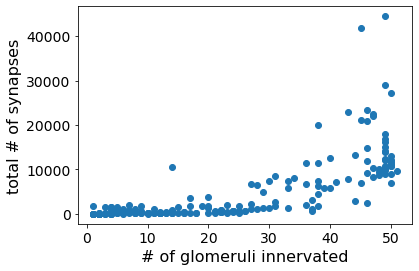

In [41]:
plt.figure()
plt.xlabel('# of glomeruli innervated')
plt.ylabel('total # of synapses')
plt.scatter((df_ln_by_glom > 0).sum(1), df_ln_by_glom.sum(1))
plt.show()

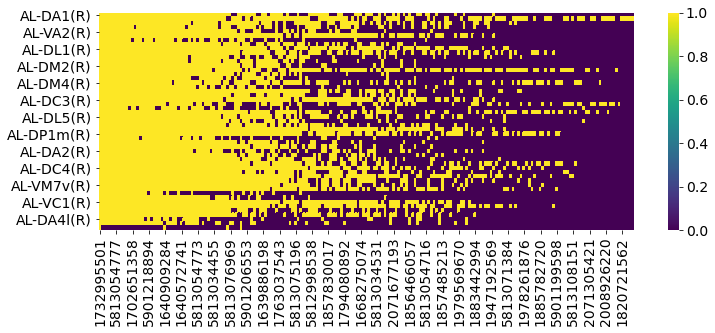

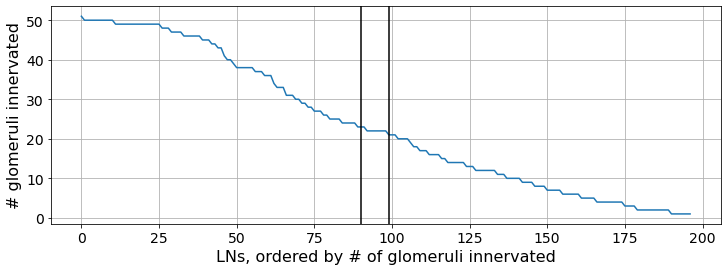

In [42]:
plot_df = (df_ln_by_glom > 0).loc[lns_by_num_gloms_innervated]
plot_df.loc[:, plot_df.sum(0).sort_values(ascending=False).index.values]

plt.figure(figsize=(12,4))
sns.heatmap(plot_df.T, cmap='viridis')
plt.show()

plt.figure(figsize=(12,4))
plt.plot(plot_df.sum(1).values)
plt.xlabel('LNs, ordered by # of glomeruli innervated')
plt.ylabel('# glomeruli innervated')
plt.axvline(90, c='k'); plt.axvline(99, color='k')
plt.grid()
plt.show()

### connectivity matrix

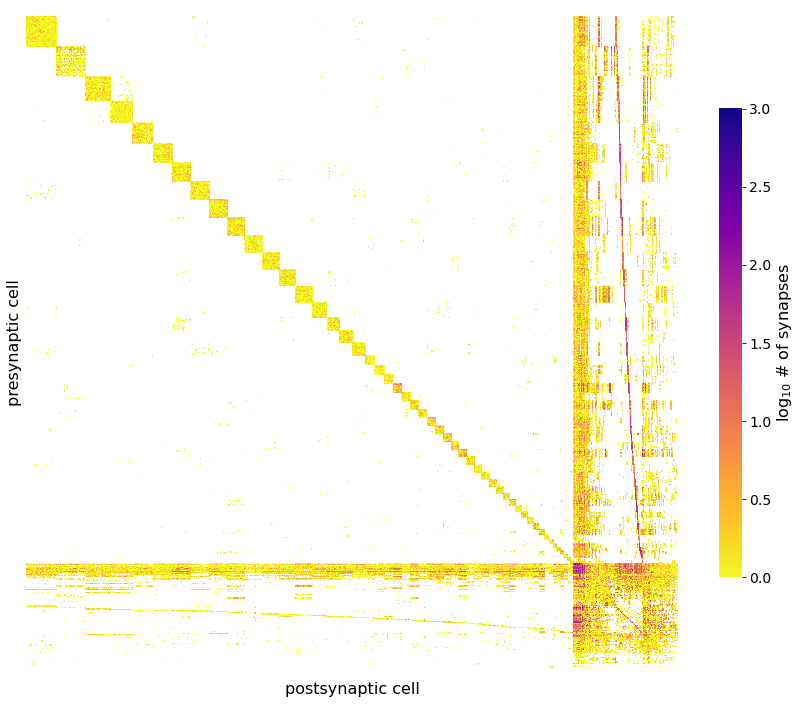

In [43]:
plt.figure(figsize=(12,10))
plt.axis('equal')
sns.heatmap(np.log10(AL_block.replace(0, np.nan)),
            cmap='plasma_r', vmin=0, cbar_kws = {'label': r'$\log_{10}$ # of synapses',
                                            'shrink': 0.7})
plt.xticks([]); plt.yticks([])
plt.xlabel('postsynaptic cell'); plt.ylabel('presynaptic cell')
plt.tight_layout()
plt.show()

Re-scaling to deemphasize the ORNs:

In [44]:
from utils.plot_utils import plot_scaled_hmap

In [45]:
final_orn_order = df_neur_ids[df_neur_ids.altype == 'ORN'].bodyId.values
final_ln_order = df_neur_ids[df_neur_ids.altype == 'LN'].bodyId.values
final_upn_order = df_neur_ids[df_neur_ids.altype == 'uPN'].bodyId.values
final_mpn_order = df_neur_ids[df_neur_ids.altype == 'mPN'].bodyId.values

In [46]:
MASTER_PLOT_DIR = '../figures/main_text_figure/'
if not os.path.exists(MASTER_PLOT_DIR):
    os.makedirs(MASTER_PLOT_DIR)

In [47]:
from matplotlib.gridspec import GridSpec

def plot_mat(mat, ax, cbar_ax, cmap='magma'):
    '''
    Helper for plot_scaled_hmap,
    plotting a single connectivity matrix (mat)

    '''
    sns.heatmap(np.log10(mat), ax=ax,
                cmap=cmap,
                vmin=0, vmax=3,
                cbar_kws={'label': r'$\log_{10}$ # synapses'},
                cbar_ax=cbar_ax)
    
def plot_scaled_hmap(fig, conmat, neur_sets, neur_set_names, cmap='jet'):
    '''
    Intended use is to plot connectivity matrix for ORNs, LNs, u/mPNs,
    adding higher visual weight to LNs
    '''
    
    n_types = len(neur_sets)
    neur_full_names = [neur_set_names[i]+'s ({})'.format(len(neur_sets[i])) for i in range(n_types)]

    p_ratios = np.ones((n_types,))
    p_ratios[1] = 2

    gs = GridSpec(n_types, n_types, 
              width_ratios=p_ratios, height_ratios=p_ratios, 
              wspace=0.025, hspace=0.025)

    cbar_ax = fig.add_axes([.92, .3, .03, .4])

    lw = 3
    axs = []
    for i in range(n_types):
        ax_rows = []
        for j in range(n_types):
            # plot the heatmap
            ax = fig.add_subplot(gs[i, j])
            mat = conmat.loc[neur_sets[i], neur_sets[j]]
            plot_mat(mat, ax, cbar_ax, cmap=cmap)

            # remove tick labels
            ax.set_yticklabels([]); ax.set_yticks([]); ax.set_ylabel('')
            ax.set_xticklabels([]); ax.set_xticks([]); ax.set_xlabel('')

            #ax.axhline(y=0, color='k',linewidth=lw) #ax.axhline(y=mat.shape[0], color='k',linewidth=lw)
            #ax.axvline(x=0, color='k',linewidth=lw) #ax.axvline(x=mat.shape[1], color='k',linewidth=lw)

            # add it to table of axes
            ax_rows.append(ax)
        axs.append(ax_rows)

    for i in range(n_types):
        axs[i][0].set_ylabel(neur_full_names[i])
        axs[n_types-1][i].set_xlabel(neur_full_names[i])

Hemibrain connectivity matrix, used in plotting Figure 4c:

C:\Users\dB\Anaconda3\envs\ALVar\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


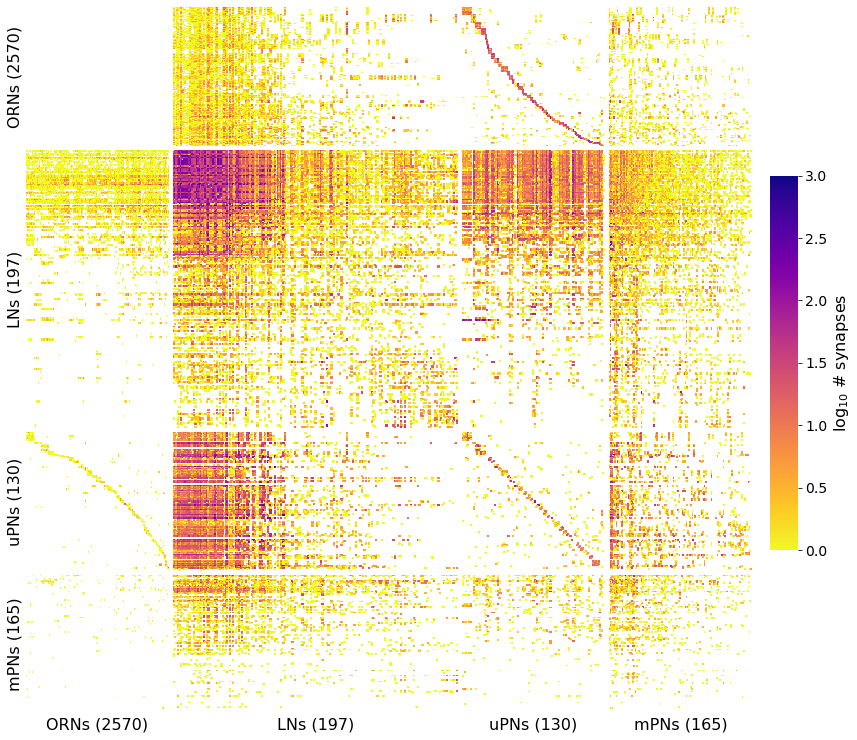

In [50]:
saveplot=0
fig = plt.figure(figsize=(13,13))
plot_scaled_hmap(fig=fig,
                 conmat = AL_block,
                 neur_sets = [final_orn_order, final_ln_order, final_upn_order, final_mpn_order],
                 neur_set_names = ['ORN', 'LN', 'uPN', 'mPN'],
                 cmap='plasma_r')
if saveplot:
    plt.savefig(os.path.join(MASTER_PLOT_DIR, 'hemibrain_connectivity_matrix_nolines.png'), dpi=1000)
    plt.savefig(os.path.join(MASTER_PLOT_DIR, 'hemibrain_connectivity_matrix_nolines.pdf'))
plt.show()

### plot individual components of heatmap


In [ ]:
save_individ = True
individ_dir = os.path.join(MASTER_PLOT_DIR, 'connectivity_matrix_individual_blocks')
if not os.path.exists(individ_dir):
    os.makedirs(individ_dir)
    


neur_sets = [final_orn_order, final_ln_order, final_upn_order, final_mpn_order]
neur_set_names = ['ORN', 'LN', 'uPN', 'mPN']
    
    
conmat = AL_block
cmap = 'plasma_r'

n_types = len(neur_sets)
neur_full_names = [neur_set_names[i]+'s ({})'.format(len(neur_sets[i])) for i in range(n_types)]

p_ratios = np.ones((n_types,))
p_ratios[1] = 2

gs = GridSpec(n_types, n_types, 
          width_ratios=p_ratios, height_ratios=p_ratios, 
          wspace=0.025, hspace=0.025)

#plt.suptitle(r'Hemibrain connectivity matrix', y=0.93)

cbar_ax = fig.add_axes([.92, .3, .03, .4])

lw = 3
axs = []
for i in range(n_types):
    ax_rows = []
    for j in range(n_types):
        # plot the heatmap
        
        fname = f'rows{neur_set_names[i]}cols{neur_set_names[j]}'
        
        if save_individ:
            fname = os.path.join(individ_dir, fname)
        fig, ax = plt.subplots(figsize=(20, 20))
        mat = conmat.loc[neur_sets[i], neur_sets[j]]
        plot_mat(mat, ax, cbar_ax, cmap=cmap)

        # remove tick labels
        ax.set_yticklabels([]); ax.set_yticks([]); ax.set_ylabel('')
        ax.set_xticklabels([]); ax.set_xticks([]); ax.set_xlabel('')
        
        plt.tight_layout()
        if save_individ:
            plt.savefig(f'{fname}.png', dpi=1000, bbox_inches='tight', pad_inches=0.01)
            plt.savefig(f'{fname}.pdf', bbox_inches='tight', pad_inches=0.01)
        plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0.05, 0.80, 0.9, 0.1])

cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal', 
                               cmap=mpl.cm.plasma_r,
                               norm=mpl.colors.Normalize(0, 3),  # vmax and vmin
                               label=r'$\log_{10}$ # synapses'
                              )
if save_individ:
    fname = os.path.join(individ_dir, 'colorbar')
    plt.savefig(f'{fname}.png', dpi=1000, bbox_inches='tight', pad_inches=0.01)
    plt.savefig(f'{fname}.pdf')